In [1]:
library(ggplot2)
library(viridis)
library(dplyr)

Loading required package: viridisLite


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
setwd("/Users/christopherhempel/Desktop/jupyter_notebook_plots")

In [3]:
# Function to draw polygons on ggplots that include X% of points, taken from https://stackoverflow.com/questions/30301108/plot-a-circle-convex-hull-arround-a-given-percentage-of-points
# Here's the stat_
StatBag <- ggproto("Statbag", Stat,
                   compute_group = function(data, scales, prop = 0.5) {

                     #################################
                     #################################
                     # originally from aplpack package, plotting functions removed
                     plothulls_ <- function(x, y, fraction, n.hull = 1,
                                            col.hull, lty.hull, lwd.hull, density=0, ...){
                       # function for data peeling:
                       # x,y : data
                       # fraction.in.inner.hull : max percentage of points within the hull to be drawn
                       # n.hull : number of hulls to be plotted (if there is no fractiion argument)
                       # col.hull, lty.hull, lwd.hull : style of hull line
                       # plotting bits have been removed, BM 160321
                       # pw 130524
                       if(ncol(x) == 2){ y <- x[,2]; x <- x[,1] }
                       n <- length(x)
                       if(!missing(fraction)) { # find special hull
                         n.hull <- 1
                         if(missing(col.hull)) col.hull <- 1
                         if(missing(lty.hull)) lty.hull <- 1
                         if(missing(lwd.hull)) lwd.hull <- 1
                         x.old <- x; y.old <- y
                         idx <- chull(x,y); x.hull <- x[idx]; y.hull <- y[idx]
                         for( i in 1:(length(x)/3)){
                           x <- x[-idx]; y <- y[-idx]
                           if( (length(x)/n) < fraction ){
                             return(cbind(x.hull,y.hull))
                           }
                           idx <- chull(x,y); x.hull <- x[idx]; y.hull <- y[idx];
                         }
                       }
                       if(missing(col.hull)) col.hull <- 1:n.hull
                       if(length(col.hull)) col.hull <- rep(col.hull,n.hull)
                       if(missing(lty.hull)) lty.hull <- 1:n.hull
                       if(length(lty.hull)) lty.hull <- rep(lty.hull,n.hull)
                       if(missing(lwd.hull)) lwd.hull <- 1
                       if(length(lwd.hull)) lwd.hull <- rep(lwd.hull,n.hull)
                       result <- NULL
                       for( i in 1:n.hull){
                         idx <- chull(x,y); x.hull <- x[idx]; y.hull <- y[idx]
                         result <- c(result, list( cbind(x.hull,y.hull) ))
                         x <- x[-idx]; y <- y[-idx]
                         if(0 == length(x)) return(result)
                       }
                       result
                     } # end of definition of plothulls
                     #################################


                     # prepare data to go into function below
                     the_matrix <- matrix(data = c(data$x, data$y), ncol = 2)

                     # get data out of function as df with names
                     setNames(data.frame(plothulls_(the_matrix, fraction = prop)), nm = c("x", "y"))
                     # how can we get the hull and loop vertices passed on also?
                   },

                   required_aes = c("x", "y")
)


# Here's the stat_ function
#' @inheritParams ggplot2::stat_identity
#' @param prop Proportion of all the points to be included in the bag (default is 0.5)
stat_bag <- function(mapping = NULL, data = NULL, geom = "polygon",
                     position = "identity", na.rm = FALSE, show.legend = NA, 
                     inherit.aes = TRUE, prop = 0.5, alpha = 0.3, ...) {
  layer(
    stat = StatBag, data = data, mapping = mapping, geom = geom, 
    position = position, show.legend = show.legend, inherit.aes = inherit.aes,
    params = list(na.rm = na.rm, prop = prop, alpha = alpha, ...)
  )
}

# here's the geom_
geom_bag <- function(mapping = NULL, data = NULL,
                     stat = "identity", position = "identity",
                     prop = 0.5, 
                     alpha = 0.3,
                     ...,
                     na.rm = FALSE,
                     show.legend = NA,
                     inherit.aes = TRUE) {
  layer(
    data = data,
    mapping = mapping,
    stat = StatBag,
    geom = GeomBag,
    position = position,
    show.legend = show.legend,
    inherit.aes = inherit.aes,
    params = list(
      na.rm = na.rm,
      alpha = alpha,
      prop = prop,
      ...
    )
  )
}

#' @rdname ggplot2-ggproto
#' @format NULL
#' @usage NULL
#' @export
GeomBag <- ggproto("GeomBag", Geom,
                   draw_group = function(data, panel_scales, coord) {
                     n <- nrow(data)
                     if (n == 1) return(zeroGrob())

                     munched <- coord_munch(coord, data, panel_scales)
                     # Sort by group to make sure that colors, fill, etc. come in same order
                     munched <- munched[order(munched$group), ]

                     # For gpar(), there is one entry per polygon (not one entry per point).
                     # We'll pull the first value from each group, and assume all these values
                     # are the same within each group.
                     first_idx <- !duplicated(munched$group)
                     first_rows <- munched[first_idx, ]

                     ggplot2:::ggname("geom_bag",
                                      grid:::polygonGrob(munched$x, munched$y, default.units = "native",
                                                         id = munched$group,
                                                         gp = grid::gpar(
                                                           col = first_rows$colour,
                                                           fill = alpha(first_rows$fill, first_rows$alpha),
                                                           lwd = first_rows$size * .pt,
                                                           lty = first_rows$linetype
                                                         )
                                      )
                     )


                   },

                   default_aes = aes(colour = "NA", fill = "grey20", size = 0.5, linetype = 1,
                                     alpha = NA, prop = 0.5),

                   handle_na = function(data, params) {
                     data
                   },

                   required_aes = c("x", "y"),

                   draw_key = draw_key_polygon
)

In [4]:
# Make plot functions

# Function for plain plot
plainplot = function (df, column1, column2, colour, xlab, ylab) {
  ggplot(df, aes_string(x=column1, y=column2)) +
  geom_point(size=5, shape=20, colour=colour) +
  xlab(xlab) + 
  ylab(ylab) +
  theme_classic() +
  theme(axis.text=element_text(size=20), axis.title=element_text(size=25,face="bold"), legend.title=element_text(size=15, face="bold"), legend.text=element_text(size=12))
  #geom_text(label=df$pipeline) # Labels
}

# Function for coloured plot
colourplot = function (df, column1, column2, group, colour, xlab, ylab, legend_title) {
  ggplot(df, aes_string(x=column1, y=column2, group=group)) +
  geom_point(aes_string(color=group), size=5, shape=20) +
  guides(colour = guide_legend(override.aes = list(size=15))) +
  scale_color_manual(values=colour) + # Manual colours
  xlab(xlab) + 
  ylab(ylab) +
  labs(colour=legend_title) +
  theme_classic() +
  theme(axis.text=element_text(size=20), axis.title=element_text(size=25,face="bold"), legend.title=element_text(size=15, face="bold"), legend.text=element_text(size=12))
  #geom_text(label=df$pipeline) # Labels
}

# Function for coloured polygon plot, polygons cover x% of points per group
polygonplot = function (df, column1, column2, group, colour, xlab, ylab, legend_title, percent) {
ggplot(df, aes_string(x=column1, y=column2, group=group, fill=group)) +
  geom_point(aes_string(color=group), size=5, shape=20) +
  scale_color_manual(values=colour) + # Manual colours points
  scale_fill_manual(values=colour) + # Manual colours polygons
  xlab(xlab) + 
  ylab(ylab) +
  labs(colour=legend_title) +
  geom_bag(prop=percent, alpha=0.3) +
  # next line applies some regression, need to look into the stats behind it to understand what's been shown when applying this
  #stat_ellipse(aes(x=chi.square.statistics, y=ANOVA.F.statistics,color=rRNA.filter, group=rRNA.filter),type = "t", level=0.95) + 
  guides(colour = guide_legend(override.aes = list(size=15)), fill=FALSE) +
  theme_classic() +
  theme(axis.text=element_text(size=20), axis.title=element_text(size=25,face="bold"), legend.title=element_text(size=15, face="bold"), legend.text=element_text(size=12))
  #geom_text(label=df$pipeline) # Labels
}

# The following are not needed anymroe, not shown
# # Function for boxplot
# boxplot = function (df, column, colour, distance, xlab, ylab) {
#   ggplot(df, aes_string(x=column, y=distance, group=column)) +
#   geom_boxplot(aes_string(fill=column)) + 
#   scale_fill_manual(values=colour) + # Manual colours boxes
#   guides(fill=FALSE) +
#   xlab(xlab) + 
#   ylab(ylab) +
#   theme_classic()
# }

# # Function for violin plot
# violinplot = function (df, column, colour, distance, xlab, ylab) {
#   ggplot(df, aes_string(x=column, y=distance, group=column)) +
#   geom_violin(aes_string(fill=column), draw_quantiles=0.5) +
#   #stat_summary(fun=median, geom="crossbar", width=1, color="black") +
#   scale_fill_manual(values=colour) + # Manual colours boxes
#   guides(fill=FALSE) +
#   xlab(xlab) + 
#   ylab(ylab) +
#   theme_classic()
# }


# FOR VARYING ALPHAS:
#scale_alpha_discrete(range = c(0.35, 0.9))

In [5]:
df = read.csv("chi2_var.csv")
df$trimmed.PHRED = as.character(df$trimmed.PHRED)
df
#df = df[order(df$rRNA.filter),]
#df$rRNA.filter = factor(df$rRNA.filter, levels = c("SORTMERNA", "BARRNAP", "rRNAFILTER", "UNSORTED"))
#df = arrange(match(df, c("SORTMERNA", "BARRNAP", "rRNAFILTER", "UNSORTED")))
#df[order(factor(df,levels = c("SORTMERNA", "BARRNAP", "rRNAFILTER", "UNSORTED")))]

pipeline                                               
1    15_rRNAFILTER_RNASPADES_BOWTIE2_SILVA_KRAKEN2          
2    5_rRNAFILTER_IDBA_UD_BOWTIE2_NCBI_NT_BLAST_FILTERED    
3    10_UNSORTED_RNASPADES_BWA_NCBI_NT_BLAST_FIRST_HIT      
4    5_BARRNAP_TRANSABYSS_BWA_SILVA_KRAKEN2                 
5    20_SORTMERNA_METASPADES_BWA_NCBI_NT_KRAKEN2            
6    20_rRNAFILTER_RNASPADES_BWA_NCBI_NT_BLAST_FILTERED     
7    15_BARRNAP_TRINITY_BOWTIE2_NCBI_NT_BLAST_FIRST_HIT     
8    15_rRNAFILTER_METASPADES_BOWTIE2_SILVA_BLAST_FIRST_HIT 
9    15_BARRNAP_TRANSABYSS_BWA_NCBI_NT_KRAKEN2              
10   10_rRNAFILTER_TRANSABYSS_BOWTIE2_NCBI_NT_BLAST_FILTERED
11   10_UNSORTED_IDBA_UD_BOWTIE2_NCBI_NT_KRAKEN2            
12   15_BARRNAP_TRANSABYSS_BOWTIE2_NCBI_NT_BLAST_FIRST_HIT  
13   20_SORTMERNA_RNASPADES_BWA_NCBI_NT_KRAKEN2             
14   5_SORTMERNA_METASPADES_BOWTIE2_SILVA_BLAST_FIRST_HIT   
15   10_BARRNAP_RNASPADES_BWA_SILVA_KRAKEN2                 
16   10_rRNAFILTER_METASPADES_BOWTIE2_NCBI_NT_BLAST_FILTERED
17   5_rRNAFILTER_TRINITY_BWA_NCBI_NT_KRAKEN2               
18   20_rRNAFILTER_IDBA_UD_BOWTIE2_NCBI_NT_KRAKEN2          
19   10_SORTMERNA_SPADES_BOWTIE2_NCBI_NT_BLAST_FILTERED     
20   20_BARRNAP_SPADES_BOWTIE2_NCBI_NT_BLAST_FIRST_HIT      
21   5_BARRNAP_SPADES_BWA_SILVA_BLAST_FIRST_HIT             
22   20_UNSORTED_METASPADES_BOWTIE2_NCBI_NT_BLAST_FILTERED  
23   15_BARRNAP_RNASPADES_BOWTIE2_NCBI_NT_BLAST_FIRST_HIT   
24   15_UNSORTED_IDBA_UD_BWA_SILVA_BLAST_FIRST_HIT          
25   10_BARRNAP_RNASPADES_BOWTIE2_NCBI_NT_BLAST_FILTERED    
26   5_SORTMERNA_IDBA_TRAN_BWA_NCBI_NT_BLAST_FILTERED       
27   15_rRNAFILTER_SPADES_BOWTIE2_SILVA_BLAST_FILTERED      
28   5_UNSORTED_IDBA_UD_BOWTIE2_SILVA_BLAST_FIRST_HIT       
29   15_SORTMERNA_METASPADES_BWA_SILVA_BLAST_FIRST_HIT      
30   20_rRNAFILTER_IDBA_TRAN_BOWTIE2_NCBI_NT_BLAST_FILTERED 
⋮    ⋮                                                      
1451 20_BARRNAP_METASPADES_BOWTIE2_NCBI_NT_BLAST_FILTERED   
1452 20_rRNAFILTER_MEGAHIT_BWA_SILVA_BLAST_FILTERED         
1453 10_SORTMERNA_TRANSABYSS_BWA_NCBI_NT_BLAST_FILTERED     
1454 5_UNSORTED_TRANSABYSS_BWA_NCBI_NT_KRAKEN2              
1455 15_UNSORTED_TRINITY_BWA_SILVA_BLAST_FIRST_HIT          
1456 10_SORTMERNA_IDBA_UD_BWA_NCBI_NT_BLAST_FIRST_HIT       
1457 10_BARRNAP_SPADES_BWA_SILVA_KRAKEN2                    
1458 10_rRNAFILTER_TRANSABYSS_BWA_SILVA_BLAST_FILTERED      
1459 20_UNSORTED_TRINITY_BOWTIE2_NCBI_NT_KRAKEN2            
1460 20_BARRNAP_METASPADES_BOWTIE2_SILVA_BLAST_FILTERED     
1461 20_rRNAFILTER_RNASPADES_BWA_SILVA_KRAKEN2              
1462 5_SORTMERNA_MEGAHIT_BOWTIE2_NCBI_NT_KRAKEN2            
1463 15_UNSORTED_IDBA_TRAN_BWA_SILVA_KRAKEN2                
1464 10_BARRNAP_IDBA_TRAN_BWA_SILVA_BLAST_FIRST_HIT         
1465 15_rRNAFILTER_RNASPADES_BOWTIE2_NCBI_NT_BLAST_FIRST_HIT
1466 10_BARRNAP_IDBA_UD_BWA_NCBI_NT_BLAST_FILTERED          
1467 15_UNSORTED_IDBA_UD_BWA_NCBI_NT_KRAKEN2                
1468 5_SORTMERNA_SPADES_BOWTIE2_NCBI_NT_BLAST_FIRST_HIT     
1469 5_UNSORTED_SPADES_BOWTIE2_NCBI_NT_BLAST_FIRST_HIT      
1470 5_BARRNAP_IDBA_UD_BOWTIE2_NCBI_NT_BLAST_FIRST_HIT      
1471 20_BARRNAP_METASPADES_BOWTIE2_SILVA_KRAKEN2            
1472 10_rRNAFILTER_METASPADES_BOWTIE2_SILVA_KRAKEN2         
1473 5_UNSORTED_RNASPADES_BWA_SILVA_BLAST_FIRST_HIT         
1474 10_UNSORTED_IDBA_TRAN_BWA_SILVA_BLAST_FIRST_HIT        
1475 15_UNSORTED_TRINITY_BOWTIE2_SILVA_KRAKEN2              
1476 20_BARRNAP_IDBA_UD_BWA_SILVA_BLAST_FILTERED            
1477 10_BARRNAP_RNASPADES_BWA_SILVA_BLAST_FILTERED          
1478 20_rRNAFILTER_SPADES_BOWTIE2_SILVA_BLAST_FIRST_HIT     
1479 10_rRNAFILTER_SPADES_BWA_NCBI_NT_KRAKEN2               
1480 20_SORTMERNA_IDBA_UD_BOWTIE2_NCBI_NT_BLAST_FIRST_HIT   
     chi.square.statistics summed.variance normalized.chi.square.statistics
1    269262329721          28095330272     0.7454565                       
2    471562438929          20467324767     0.5515353                   

In [6]:
col1="normalized.chi.square.statistics"
col2="normalized.summed.variance"
title_x="Accuracy"
title_y="Precision"
perc_poly=0.90

In [7]:
# TO DO: run DNA samples, make separate DNA and RNA df and concatenate them,
# add plot coloured by RNA/DNA, see if clear "winner", if yes, look into that one only for all steps,
# if no look at concatenated fdfor all steps

pdf 
  2

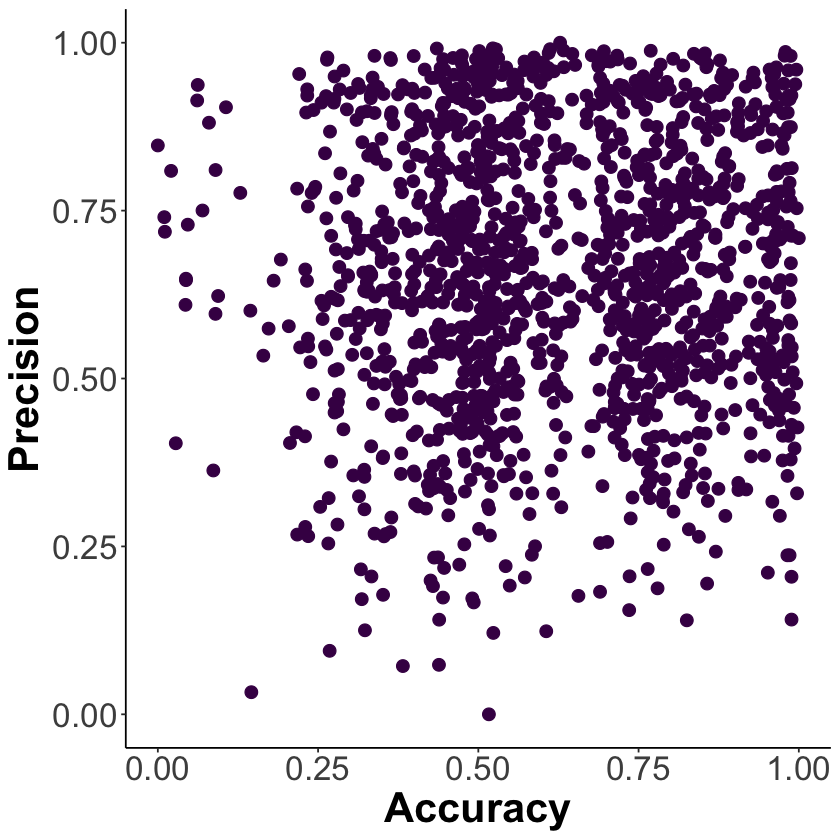

In [8]:
# Plot uncoloured
## Make colours
colours_vir = viridis_pal(option = "D")(1)

## Plot plot in preview
plainplot(df, col1, col2, colours_vir, title_x, title_y)

## Save plot in workdir
jpeg("plot_plain.jpg", width = 1200, height = 800)
plainplot(df, col1, col2, colours_vir, title_x, title_y)
dev.off()

In [9]:
groups_to_plot=c("trimmed.PHRED", "rRNA.filter", "assembler", "mapper", "DF", "classification")


pdf 
  2

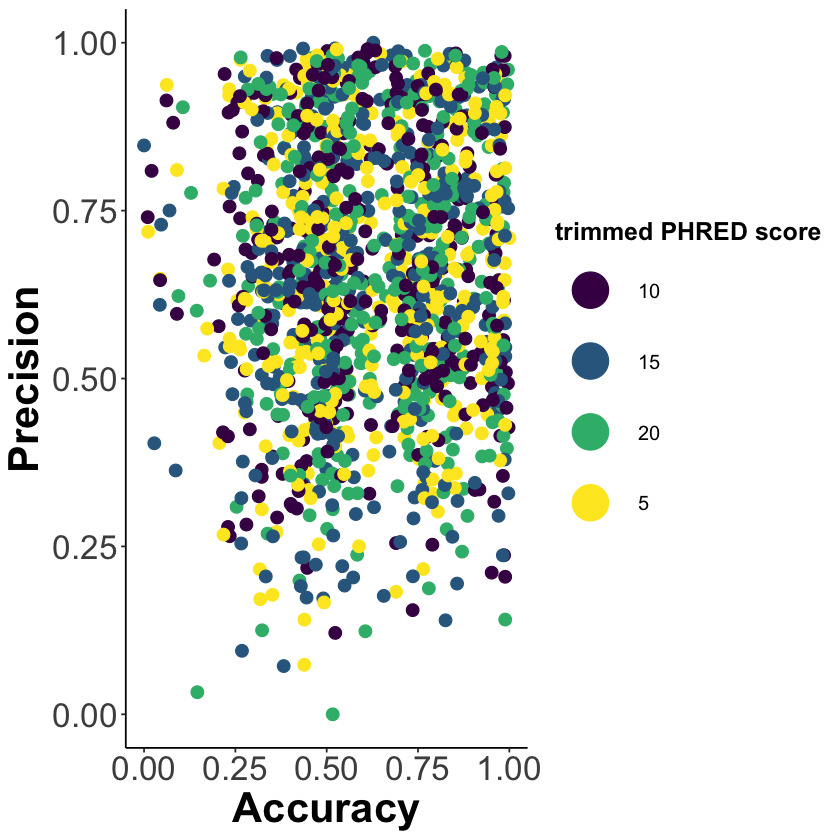

pdf 
  2

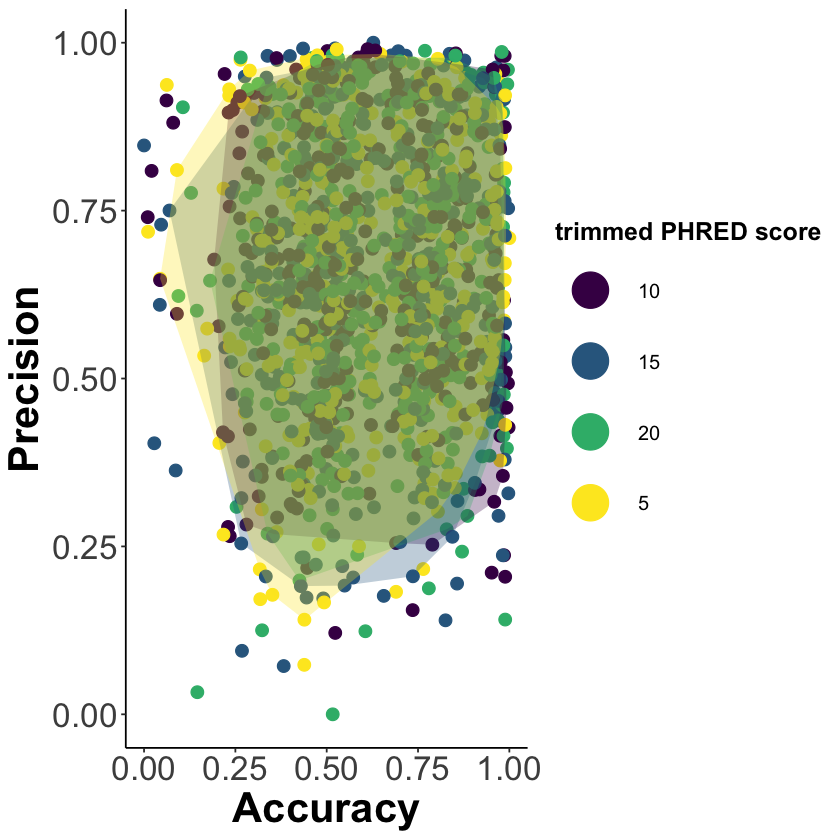

In [10]:
# Coloured by trimmedf PHRED score
## Set variables
group="trimmed.PHRED"
title="trimmed PHRED score"
colours_vir = viridis_pal(option = "D")(length(unique(df[[group]])))
# colours_vir_grey = c('#d3d3d3','#d3d3d3','#21908CFF', '#d3d3d3')


## Plot coloured plot in preview
colourplot(df, col1, col2, group, colours_vir, title_x, title_y, title)

## Save coloured plot in workdir
jpeg("plot_trimmed.jpg", width = 1200, height = 800)
colourplot(df, col1, col2, group, colours_vir, title_x, title_y, title)
dev.off()

# ## Plot coloured plot with greys in preview
# colourplot(df, col1, col2, group, colours_vir_grey, title_x, title_y, title)

# ## Save coloured plot with greys in workdir
# jpeg("plot_trimmed_greys.jpg", width = 1200, height = 800)
# colourplot(df, col1, col2, group, colours_vir_grey, title_x, title_y, title)
# dev.off()

## Plot polygon plot in preview
polygonplot(df, col1, col2, group, colours_vir, title_x, title_y, title, perc_poly)

## Save polygon plot in workdir
jpeg("plot_trimmed_polygons.jpg", width = 1200, height = 800)
polygonplot(df, col1, col2, group, colours_vir, title_x, title_y, title, perc_poly)
dev.off()

# ## Plot violin plot in preview
# violinplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")

# ## Save violin plot in workdir
# jpeg("plot_phred_violin.jpg", width = 1200, height = 800)
# violinplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")
# dev.off()

# ## Plot boxplot in preview
# boxplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")

# ## Save boxplot in workdir
# jpeg("plot_phred_boxplot.jpg", width = 1200, height = 800)
# boxplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")
# dev.off()

pdf 
  2

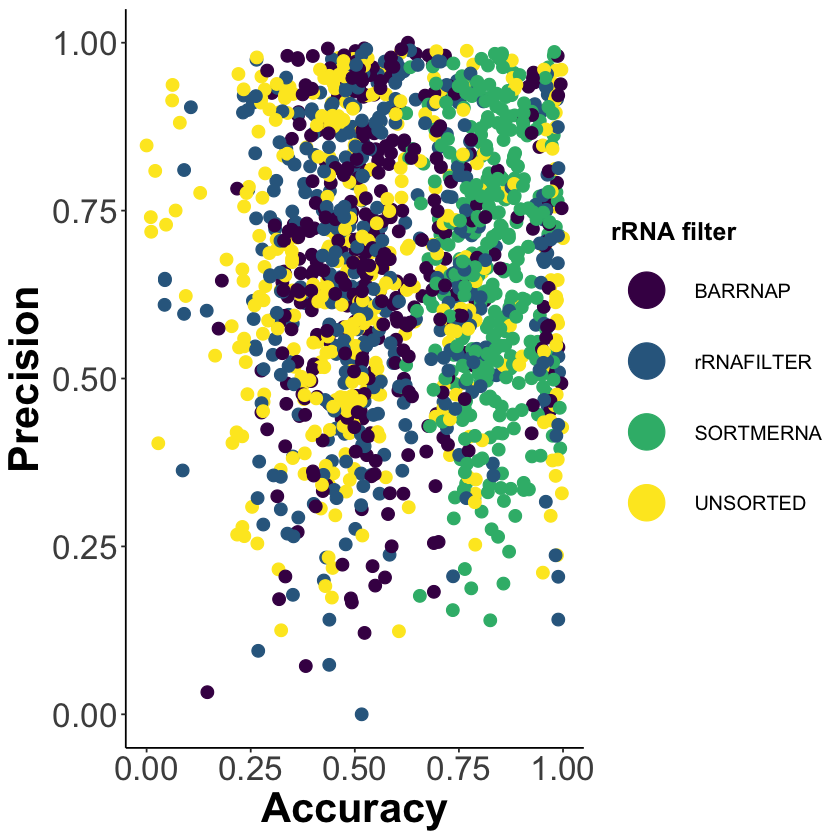

pdf 
  2

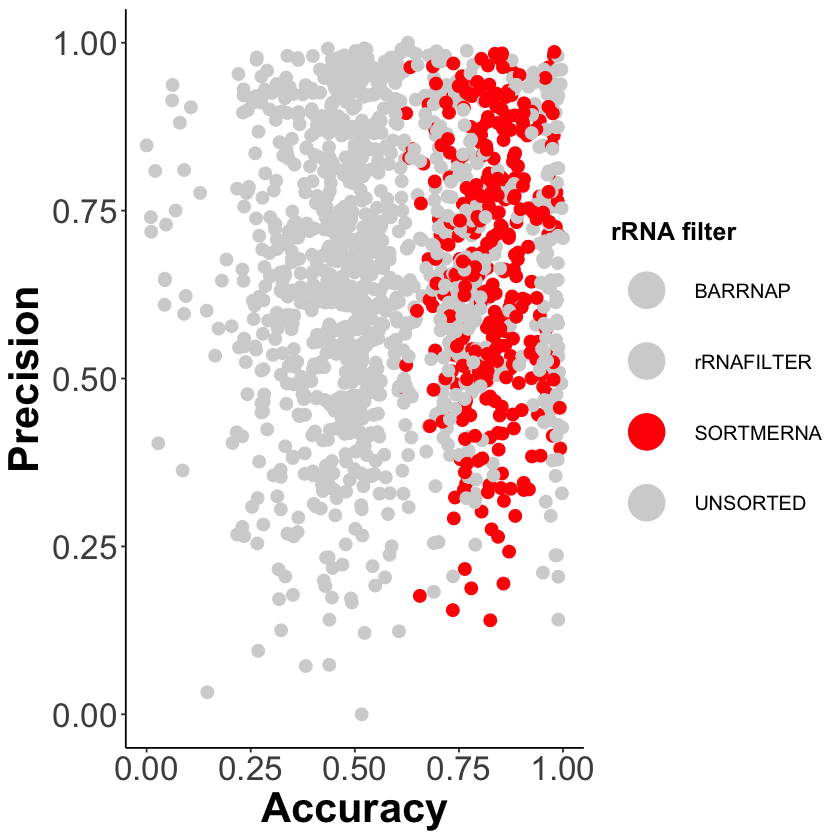

pdf 
  2

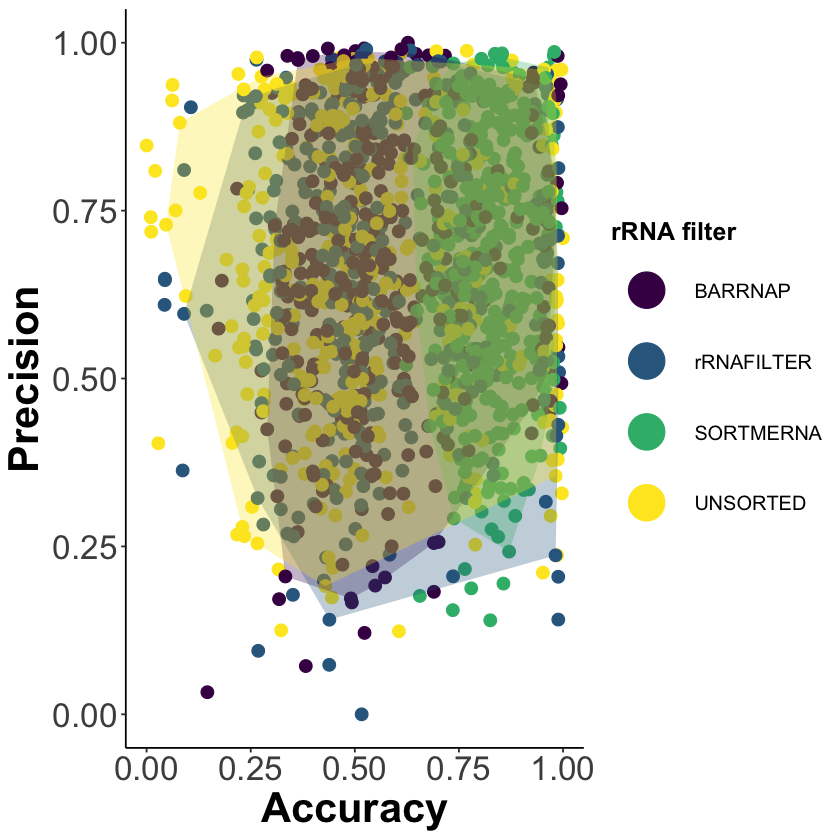

In [11]:
# Coloured by trimmedf PHRED score
## Set variables
group="rRNA.filter"
title="rRNA filter"
colours_vir = viridis_pal(option = "D")(length(unique(df[[group]])))
colours_vir_grey = c('#d3d3d3','#d3d3d3','#FF0000', '#d3d3d3')


## Plot coloured plot in preview
colourplot(df, col1, col2, group, colours_vir, title_x, title_y, title)

## Save coloured plot in workdir
jpeg("plot_rrnafilter.jpg", width = 1200, height = 800)
colourplot(df, col1, col2, group, colours_vir, title_x, title_y, title)
dev.off()

## Plot coloured plot with greys in preview
colourplot(df, col1, col2, group, colours_vir_grey, title_x, title_y, title)

## Save coloured plot with greys in workdir
jpeg("plot_rrnafilter_greys.jpg", width = 1200, height = 800)
colourplot(df, col1, col2, group, colours_vir_grey, title_x, title_y, title)
dev.off()

## Plot polygon plot in preview
polygonplot(df, col1, col2, group, colours_vir, title_x, title_y, title, perc_poly)

## Save polygon plot in workdir
jpeg("plot_rrnafilter_polygons.jpg", width = 1200, height = 800)
polygonplot(df, col1, col2, group, colours_vir, title_x, title_y, title, perc_poly)
dev.off()

# ## Plot violin plot in preview
# violinplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")

# ## Save violin plot in workdir
# jpeg("plot_phred_violin.jpg", width = 1200, height = 800)
# violinplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")
# dev.off()

# ## Plot boxplot in preview
# boxplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")

# ## Save boxplot in workdir
# jpeg("plot_phred_boxplot.jpg", width = 1200, height = 800)
# boxplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")
# dev.off()

pdf 
  2

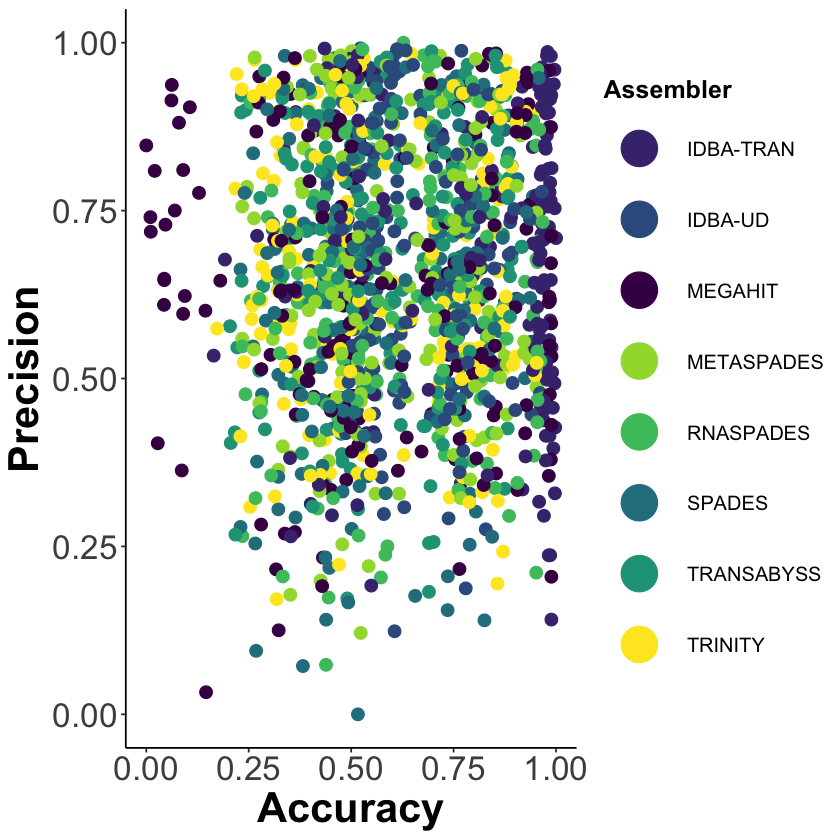

pdf 
  2

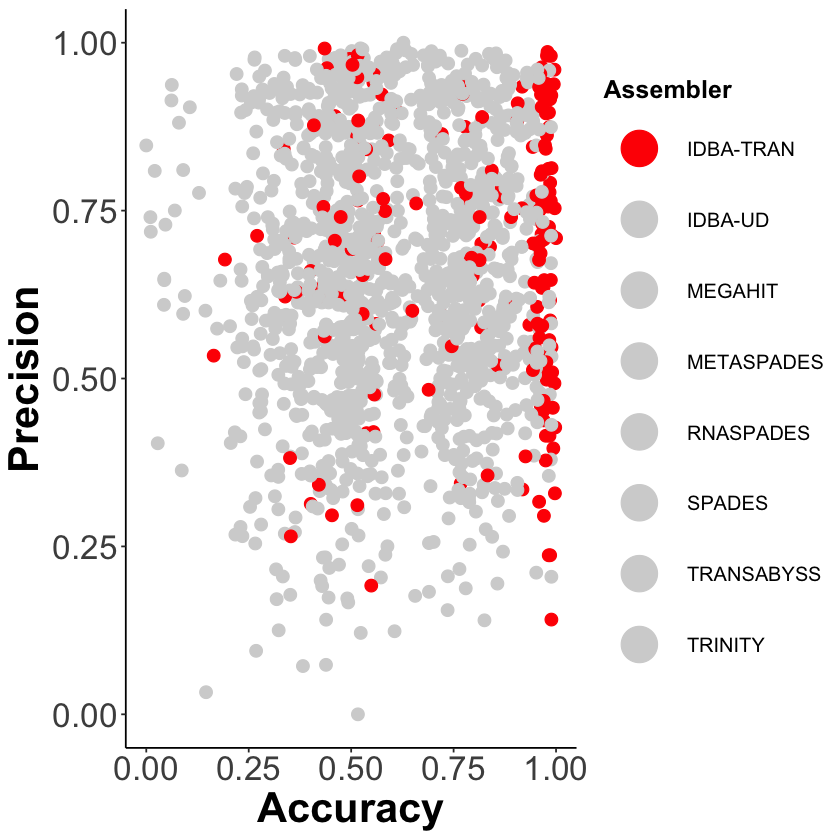

pdf 
  2

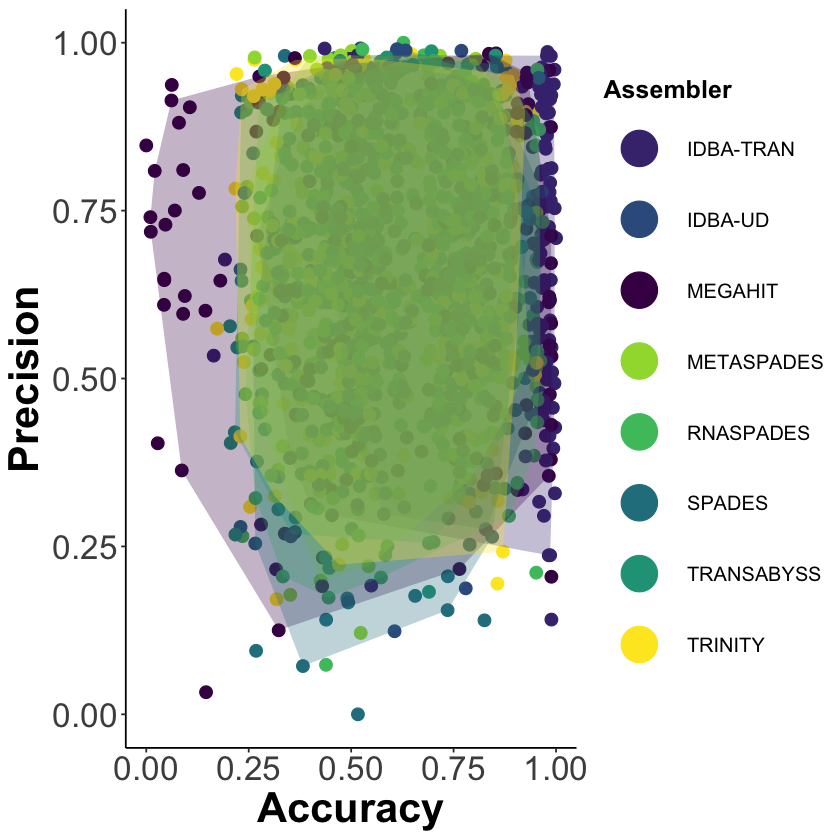

In [12]:
# Coloured by assembler
## Make colours
group = "assembler"
title="Assembler"
set.seed(005)
colours_vir = sample(viridis_pal(option = "D")(length(unique(df[[group]])))) # Randomize color order, otherwise dots next to each other are hard to distinguish
colours_vir_grey = c('#FF0000', '#d3d3d3', '#d3d3d3', '#d3d3d3', '#d3d3d3', '#d3d3d3', '#d3d3d3', '#d3d3d3')


## Plot coloured plot in preview
colourplot(df, col1, col2, group, colours_vir, title_x, title_y, title)

## Save coloured plot in workdir
jpeg("plot_assembler.jpg", width = 1200, height = 800)
colourplot(df, col1, col2, group, colours_vir, title_x, title_y, title)
dev.off()

## Plot coloured plot with greys in preview
colourplot(df, col1, col2, group, colours_vir_grey, title_x, title_y, title)

## Save coloured plot with greys in workdir
jpeg("plot_assembler_greys.jpg", width = 1200, height = 800)
colourplot(df, col1, col2, group, colours_vir_grey, title_x, title_y, title)
dev.off()

## Plot polygon plot in preview
polygonplot(df, col1, col2, group, colours_vir, title_x, title_y, title, perc_poly)

## Save polygon plot in workdir
jpeg("plot_assembler_polygons.jpg", width = 1200, height = 800)
polygonplot(df, col1, col2, group, colours_vir, title_x, title_y, title, perc_poly)
dev.off()

# ## Plot violin plot in preview
# violinplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")

# ## Save violin plot in workdir
# jpeg("plot_phred_violin.jpg", width = 1200, height = 800)
# violinplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")
# dev.off()

# ## Plot boxplot in preview
# boxplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")

# ## Save boxplot in workdir
# jpeg("plot_phred_boxplot.jpg", width = 1200, height = 800)
# boxplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")
# dev.off()

pdf 
  2

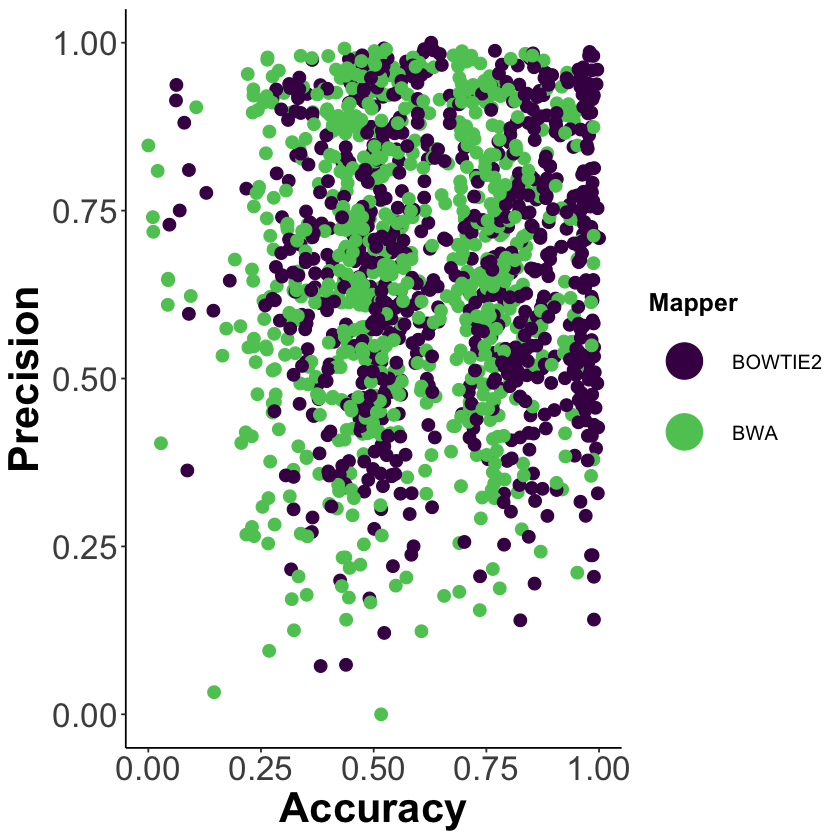

pdf 
  2

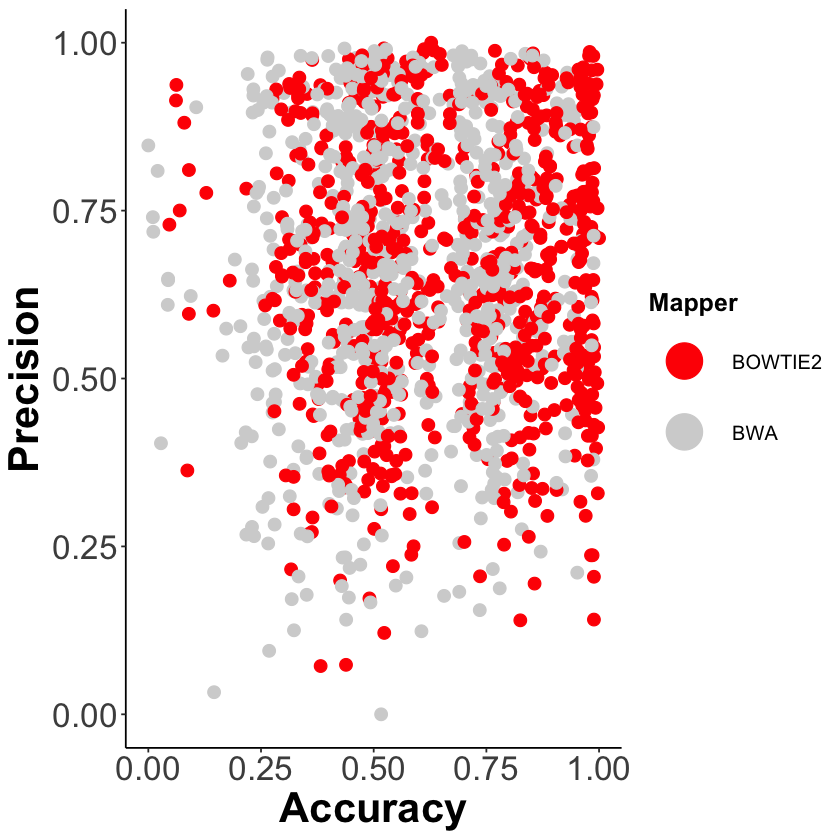

pdf 
  2

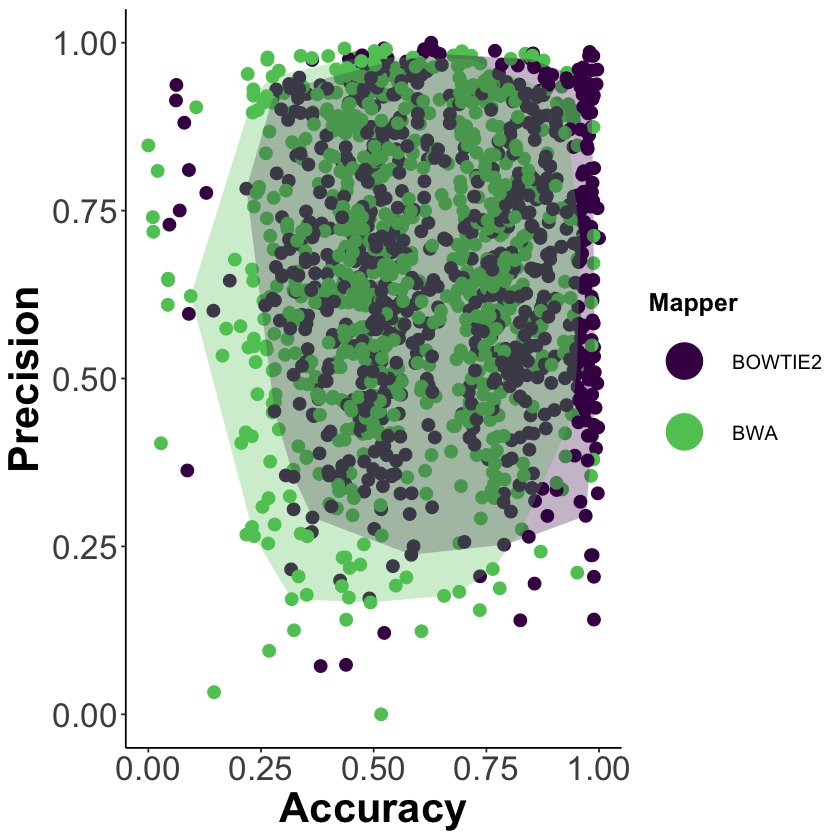

In [13]:
# Coloured by mapper
## Make colours
group = "mapper"
title="Mapper"
colours_vir = viridis_pal(option = "D")(5)[c(1, 4)]
colours_vir_grey = c('#FF0000','#d3d3d3')


## Plot coloured plot in preview
colourplot(df, col1, col2, group, colours_vir, title_x, title_y, title)

## Save coloured plot in workdir
jpeg("plot_mapper.jpg", width = 1200, height = 800)
colourplot(df, col1, col2, group, colours_vir, title_x, title_y, title)
dev.off()

## Plot coloured plot with greys in preview
colourplot(df, col1, col2, group, colours_vir_grey, title_x, title_y, title)

## Save coloured plot with greys in workdir
jpeg("plot_mapper_greys.jpg", width = 1200, height = 800)
colourplot(df, col1, col2, group, colours_vir_grey, title_x, title_y, title)
dev.off()

## Plot polygon plot in preview
polygonplot(df, col1, col2, group, colours_vir, title_x, title_y, title, perc_poly)

## Save polygon plot in workdir
jpeg("plot_mapper_polygons.jpg", width = 1200, height = 800)
polygonplot(df, col1, col2, group, colours_vir, title_x, title_y, title, perc_poly)
dev.off()

# ## Plot violin plot in preview
# violinplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")

# ## Save violin plot in workdir
# jpeg("plot_phred_violin.jpg", width = 1200, height = 800)
# violinplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")
# dev.off()

# ## Plot boxplot in preview
# boxplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")

# ## Save boxplot in workdir
# jpeg("plot_phred_boxplot.jpg", width = 1200, height = 800)
# boxplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")
# dev.off()

pdf 
  2

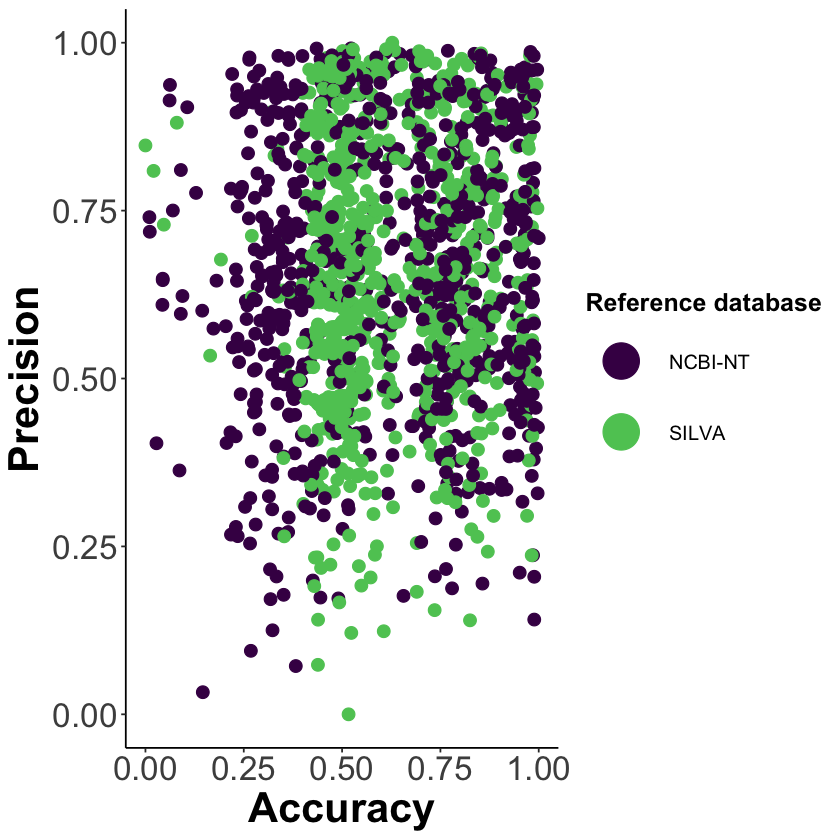

pdf 
  2

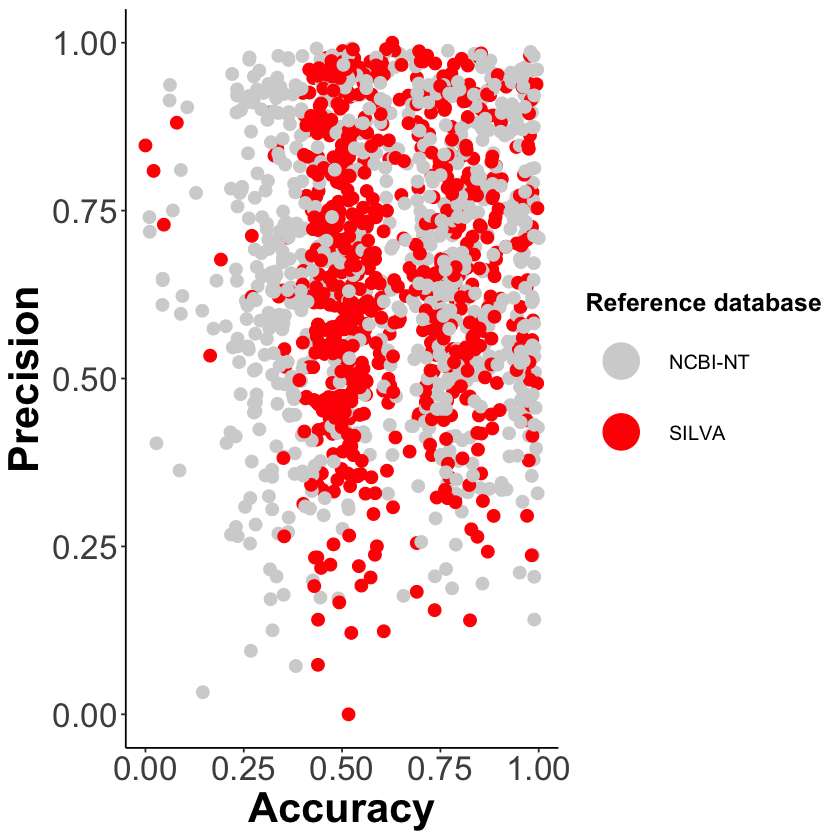

pdf 
  2

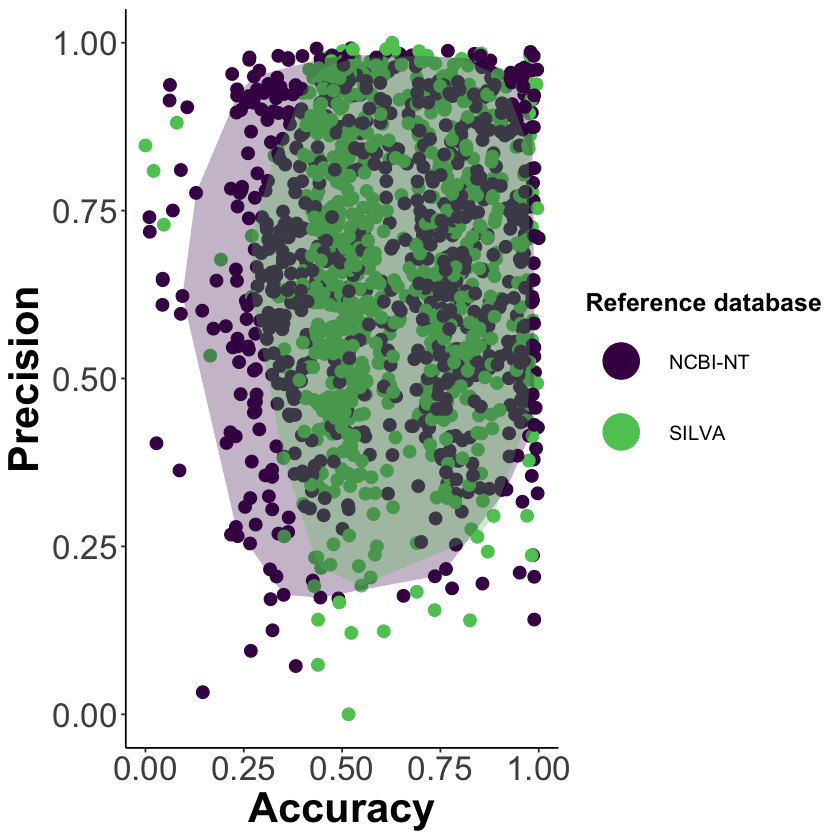

In [14]:
# Coloured by DB
## Make colours
group = "DB"
title="Reference database"
colours_vir = viridis_pal(option = "D")(5)[c(1, 4)]
colours_vir_grey = c('#d3d3d3','#FF0000')


## Plot coloured plot in preview
colourplot(df, col1, col2, group, colours_vir, title_x, title_y, title)

## Save coloured plot in workdir
jpeg("plot_DB.jpg", width = 1200, height = 800)
colourplot(df, col1, col2, group, colours_vir, title_x, title_y, title)
dev.off()

## Plot coloured plot with greys in preview
colourplot(df, col1, col2, group, colours_vir_grey, title_x, title_y, title)

## Save coloured plot with greys in workdir
jpeg("plot_DB_greys.jpg", width = 1200, height = 800)
colourplot(df, col1, col2, group, colours_vir_grey, title_x, title_y, title)
dev.off()

## Plot polygon plot in preview
polygonplot(df, col1, col2, group, colours_vir, title_x, title_y, title, perc_poly)

## Save polygon plot in workdir
jpeg("plot_DB_polygons.jpg", width = 1200, height = 800)
polygonplot(df, col1, col2, group, colours_vir, title_x, title_y, title, perc_poly)
dev.off()

# ## Plot violin plot in preview
# violinplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")

# ## Save violin plot in workdir
# jpeg("plot_phred_violin.jpg", width = 1200, height = 800)
# violinplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")
# dev.off()

# ## Plot boxplot in preview
# boxplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")

# ## Save boxplot in workdir
# jpeg("plot_phred_boxplot.jpg", width = 1200, height = 800)
# boxplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")
# dev.off()

[1] "#440154FF" "#21908CFF" "#FDE725FF"

pdf 
  2

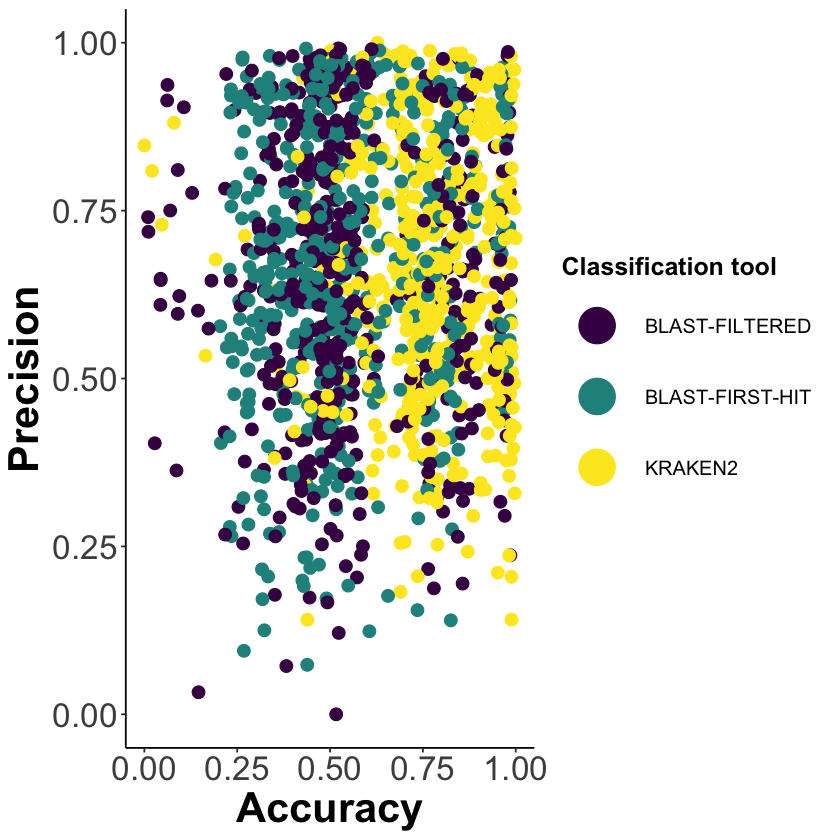

pdf 
  2

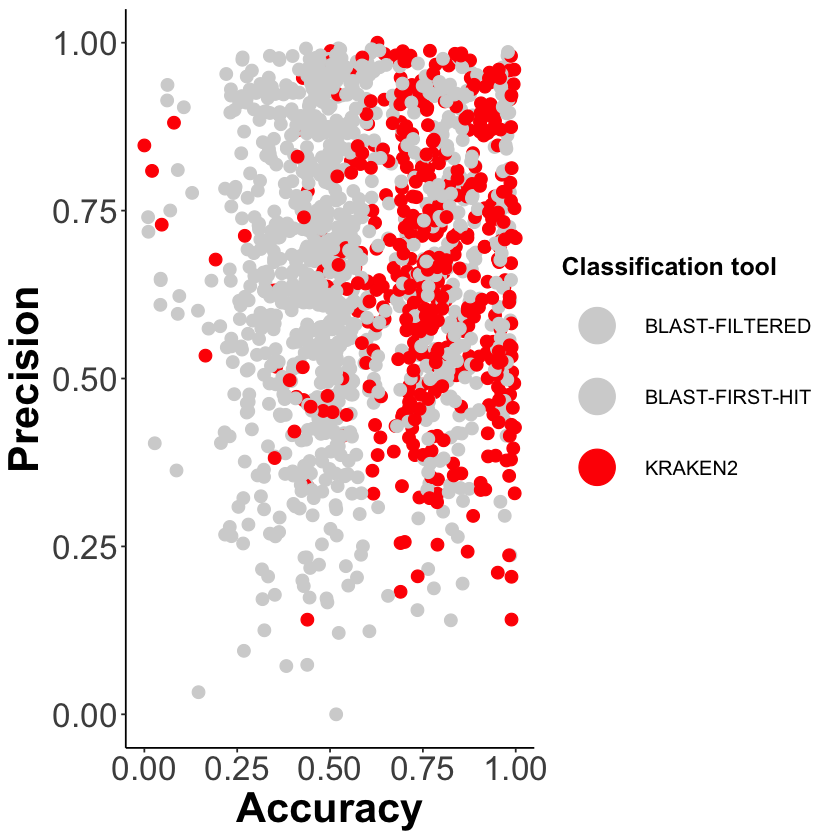

pdf 
  2

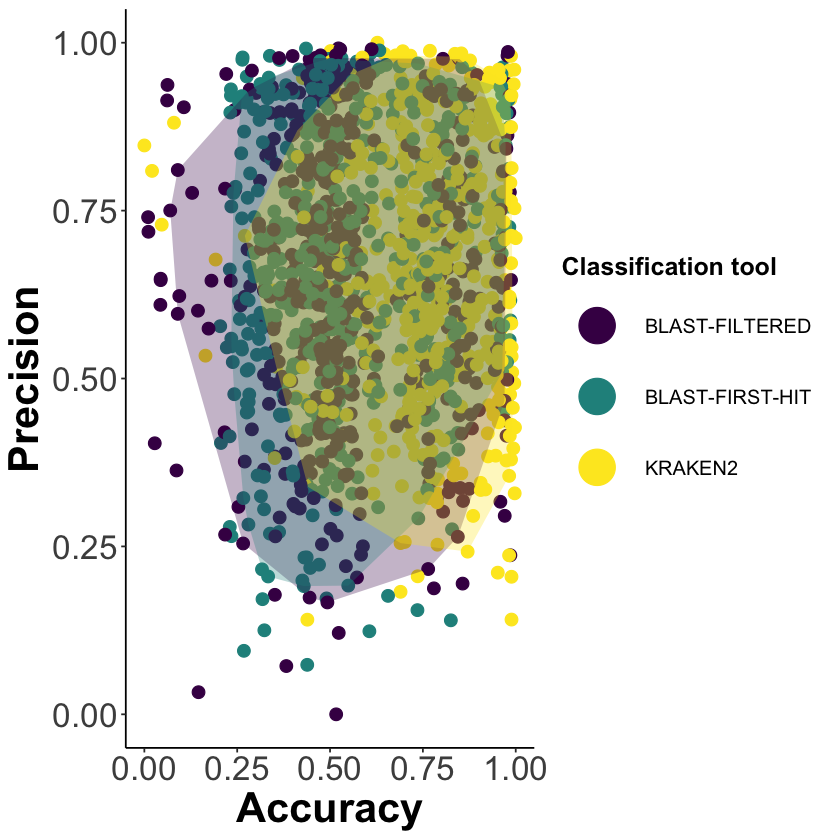

In [15]:
# Coloured by classification
## Make colours
group = "classification"
title="Classification tool"
colours_vir = viridis_pal(option = "D")(length(unique(df[[group]])))
colours_vir
colours_vir_grey = c('#d3d3d3','#d3d3d3','#FF0000')


## Plot coloured plot in preview
colourplot(df, col1, col2, group, colours_vir, title_x, title_y, title)

## Save coloured plot in workdir
jpeg("plot_classification.jpg", width = 1200, height = 800)
colourplot(df, col1, col2, group, colours_vir, title_x, title_y, title)
dev.off()

## Plot coloured plot with greys in preview
colourplot(df, col1, col2, group, colours_vir_grey, title_x, title_y, title)

## Save coloured plot with greys in workdir
jpeg("plot_classification_greys.jpg", width = 1200, height = 800)
colourplot(df, col1, col2, group, colours_vir_grey, title_x, title_y, title)
dev.off()

## Plot polygon plot in preview
polygonplot(df, col1, col2, group, colours_vir, title_x, title_y, title, perc_poly)

## Save polygon plot in workdir
jpeg("plot_classification_polygons.jpg", width = 1200, height = 800)
polygonplot(df, col1, col2, group, colours_vir, title_x, title_y, title, perc_poly)
dev.off()

# ## Plot violin plot in preview
# violinplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")

# ## Save violin plot in workdir
# jpeg("plot_phred_violin.jpg", width = 1200, height = 800)
# violinplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")
# dev.off()

# ## Plot boxplot in preview
# boxplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")

# ## Save boxplot in workdir
# jpeg("plot_phred_boxplot.jpg", width = 1200, height = 800)
# boxplot(df, group, colours_vir, "distance.from.origin", title, "Distance to origin")
# dev.off()